## Build and compress index files and metadata

list of tickers: https://quant.stackexchange.com/questions/1640/where-to-download-list-of-all-common-stocks-traded-on-nyse-nasdaq-and-amex/1862#1862

In [1]:
NUM_TICKERS = 100  # int or None for all tickers
DAYS_WINDOW = 30

In [2]:
import csv
import io
from ftplib import FTP
from pathlib import Path
import random

random.seed(42)


def get_us_tickers():
    """Retrieve all tickers listed on Nasdaq, NYSE and AMEX"""
    ftp_host = "ftp.nasdaqtrader.com"
    nasdaq_file = Path("Symboldirectory/nasdaqlisted.txt")
    other_file = Path("Symboldirectory/otherlisted.txt")

    tickers: list[str] = []
    with FTP(ftp_host) as ftp:
        ftp.login()

        nasdaq_io = io.BytesIO()
        ftp.retrbinary(f"RETR {nasdaq_file}", nasdaq_io.write)
        nasdaq_io.seek(0)
        nasdaq_reader = csv.DictReader(io.TextIOWrapper(nasdaq_io), delimiter="|")
        for row in nasdaq_reader:
            tickers.append(row["Symbol"])

        other_io = io.BytesIO()
        ftp.retrbinary(f"RETR {other_file}", other_io.write)
        other_io.seek(0)
        other_reader = csv.DictReader(io.TextIOWrapper(other_io), delimiter="|")
        for row in other_reader:
            tickers.append(row["ACT Symbol"])
    return tickers


ticker_symbols = get_us_tickers()
if NUM_TICKERS is not None:
    ticker_symbols = random.choices(ticker_symbols, k=NUM_TICKERS)
print(len(ticker_symbols), "tickers")

100 tickers


In [ ]:
from typing import cast

import pandas as pd
import yfinance as yf

tickers = yf.Tickers(",".join(ticker_symbols))
history_df = cast(pd.DataFrame, tickers.history(period="1y"))
print(len(history_df), "days")

[**********************77%************           ]  77 of 100 completedHTTP Error 404: 
[**********************78%************           ]  78 of 100 completedHTTP Error 404: 
[*********************100%***********************]  100 of 100 completed

6 Failed downloads:
['GNL$D', 'GDV$K', 'ASB$E', 'FLG$A', 'DLNG$B', 'TWO$A']: YFPricesMissingError('possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


250 days


In [4]:
from typing import Iterable

import numpy as np

np.random.seed(42)


def process_history(
    df: pd.DataFrame, keep_cols: Iterable[str] = ("Close", "Volume"), add_flow=True
):
    """Flow is defined as close x volume"""
    if add_flow:
        flow_df = df["Close"] * df["Volume"]
        flow_df.columns = pd.MultiIndex.from_product([["Flow"], flow_df.columns])
        df = pd.concat([df, flow_df], axis=1)

    # filter columns
    columns = list(keep_cols) + ["Flow"] if add_flow else []
    df = df[columns]
    df.columns = pd.MultiIndex.from_product(
        [columns, df.columns.levels[1]], names=df.columns.names
    )
    return df


df = process_history(history_df)
metrics: list[str] = list(df.columns.levels[0].values)

print(df.columns.levels[0], df.shape)
display(df.head())

# each metric should have the same nan masks
nan_masks = [df[c].isna().to_numpy() for c in metrics]
assert np.all(nan_masks == nan_masks[0])

Index(['Close', 'Flow', 'Volume'], dtype='object') (250, 300)


Close                                                       \
Ticker           ADEA  APLMW ARAI ASB$E       ASET  ATAI   BFRI      BHFAN   
Date                                                                         
2024-07-08  11.027448  0.026  NaN   NaN  29.342802  1.27  0.861  18.419912   
2024-07-09  10.899451  0.026  NaN   NaN  29.278181  1.32  0.890  18.150667   
2024-07-10  10.978219  0.026  NaN   NaN  29.606108  1.32  0.980  17.872141   
2024-07-11  11.155446  0.026  NaN   NaN  29.949467  1.46  1.100  18.039259   
2024-07-12  11.145598  0.026  NaN   NaN  30.132723  1.54  1.055  18.057825   

                                  ...          Flow                 \
Ticker           BWFG       BWNB  ...          USIN            UYM   
Date                              ...                                
2024-07-08  22.859467  18.274601  ...   4779.840469  155040.708733   
2024-07-09  22.284813  18.090565  ...      0.000000   24902.446747   
2024-07-10  22.586750  18.375818  ...      0.000000  163614.697266   
2024-07-11  23.482819  18.605860  ...  19235.086060  300116.445923   
2024-07-12  23.813972  19.093550  ...   4818.959427  139105.712891   

                                                                               \
Ticker               VCIG VYLD WCMI          XPEL          XPOF          XRAY   
Date                                                                            
2024-07-08  138331.893677  NaN  NaN  4.723470e+06  1.370368e+07  4.880153e+07   
2024-07-09  218773.232788  NaN  NaN  7.468629e+06  1.012502e+07  6.905542e+07   
2024-07-10   69278.158997  NaN  NaN  7.694796e+06  7.641621e+06  7.786847e+07   
2024-07-11   65963.803101  NaN  NaN  6.719496e+06  9.962933e+06  6.737741e+07   
2024-07-12  160318.192993  NaN  NaN  6.864626e+06  7.830693e+06  5.527967e+07   

                                         
Ticker              ZALT            ZIG  
Date                                     
2024-07-08  2.642804e+06  125474.994659  
2024-07-09  8.132475e+05  228863.989258  
2024-07-10  1.150524e+06   57825.598145  
2024-07-11  3.483100e+05  104916.003418  
2024-07-12  4.074776e+06   71643.301392  

[5 rows x 300 columns]

In [5]:
from sklearn.preprocessing import minmax_scale


def to_sliding_time_series(df: pd.DataFrame, window: int):
    """Create a matrix of sliding window time data series of size `window`

    Expect `df` have rows of time and columns of group.
    """
    matrix = df.to_numpy().T
    sliding_series = np.lib.stride_tricks.sliding_window_view(
        matrix, window, axis=1
    ).reshape((-1, window))

    # filter row if any value is nan
    non_nans = ~np.isnan(sliding_series).any(axis=1)
    sliding_series = sliding_series[non_nans]
    return sliding_series, non_nans


window = DAYS_WINDOW * 2  # to make sure there are data after the window
metrics_series: dict[str, np.ndarray] = {}
non_nans = None
for m in metrics:
    sliding_series, new_non_nans = to_sliding_time_series(df[m], window)
    if non_nans is not None:
        assert (non_nans == new_non_nans).all()
    non_nans = new_non_nans

    sliding_series = sliding_series[:, :DAYS_WINDOW]
    # sort of normalize the samples by clamping the data
    sliding_series = minmax_scale(sliding_series, feature_range=(0, 1), axis=1)
    metrics_series[m] = sliding_series
print(non_nans.shape, metrics_series[metrics[0]].shape)

(19100,) (15403, 30)


In [6]:
from datetime import datetime

import faiss


def create_index(vectors: np.ndarray, m=10):
    """Using IndexIVFPQ to achieve lower memory size and faster qeury"""
    dim = vectors.shape[-1]
    assert dim % m == 0
    quantizer = faiss.IndexFlatL2(dim)
    index = faiss.IndexIVFPQ(quantizer, dim, 100, m, 8)
    index.train(vectors)
    index.add(vectors)
    index.nprobe = 10
    return index


def create_index_meta(
    is_series_used: list[bool], tickers: list[str], dates: list[datetime]
):
    """Mapping from index to its ticker and start date"""
    meta_data = []
    ticker_span = len(is_series_used) // len(tickers)
    for i, used in enumerate(is_series_used):
        if not used:
            continue
        ticker_idx = i // ticker_span
        date_idx = i % ticker_span
        meta_data.append([tickers[ticker_idx], dates[date_idx].date()])
    meta_df = pd.DataFrame(meta_data, columns=["Ticker", "Start"])
    return meta_df


metric_indices = {m: create_index(s) for m, s in metrics_series.items()}
meta_df = create_index_meta(non_nans, history_df["Close"].columns, df.index)

In [7]:
import zipfile
from dataclasses import dataclass


@dataclass
class DataPack:
    history: pd.DataFrame
    indices: dict[str, faiss.Index]
    meta: pd.DataFrame

    def archive(self, file: Path | str):
        """Create a zip file to store all contents"""
        for name, index in self.indices.items():
            faiss.write_index(index, f"{name}.index")
        self.history.to_csv("history.csv")
        self.meta.to_csv("meta.csv")

        files = ["history.csv", "meta.csv"] + [f"{n}.index" for n in self.indices]
        with zipfile.ZipFile(file, "w", zipfile.ZIP_DEFLATED) as zf:
            for path in files:
                zf.write(path)
                Path(path).unlink()

    @staticmethod
    def extract(file: Path | str) -> "DataPack":
        with zipfile.ZipFile(file, "r") as zf:
            with zf.open("history.csv") as hf:
                history_df = pd.read_csv(
                    hf, header=[0, 1], index_col=0, parse_dates=True
                )
            with zf.open("meta.csv") as mf:
                meta_df = pd.read_csv(mf, parse_dates=True, date_format="%Y/%m/%d")

            indices: dict[str, faiss.Index] = {}
            for f in zf.namelist():
                if f in ("history.csv", "meta.csv"):
                    continue
                with zf.open(f) as cf:
                    reader = faiss.PyCallbackIOReader(cf.read)
                    indices[f.removesuffix(".index")] = faiss.read_index(reader)
        return DataPack(history_df, indices, meta_df)

In [8]:
DataPack(df, metric_indices, meta_df).archive("us_stock.zip")
data_pack = DataPack.extract("us_stock.zip")

### Query

In [9]:
METRICS = "Close"

In [10]:
query_df = yf.Ticker("TSLA").history("6mo")
query_data = query_df[METRICS][:DAYS_WINDOW].to_numpy()
query_data = minmax_scale(query_data, feature_range=(0, 1))
query_data = query_data.reshape((1, -1))
print(query_df.shape, query_data.shape)

(122, 7) (1, 30)


In [11]:
(dist, *_), (idx, *_) = data_pack.indices[METRICS].search(query_data, 20)
print(dist)
print(idx)

[0.22223552 0.24668166 0.27084634 0.28597522 0.28701216 0.29624856
 0.2972777  0.3084061  0.32199007 0.32641202 0.3326589  0.3413841
 0.34432733 0.35872352 0.36352944 0.36771807 0.38001186 0.3881883
 0.39405242 0.3947364 ]
[12500 11739  6204 15306  5631 15305   476 11740 11411  5630  6203  3150
  6205   477  2208  2207 14019  3149 11738 14020]


['SNAV', 'RLTY', 'IQRA', 'ZIG', 'HBAN', 'ZIG', 'ASET', 'RLTY', 'QQXT', 'HBAN', 'IQRA', 'CWS', 'IQRA', 'ASET', 'CODI', 'CODI', 'UYM', 'CWS', 'RLTY', 'UYM']


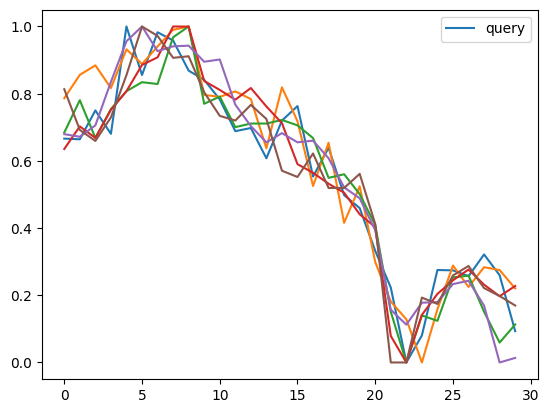

In [12]:
from matplotlib import pyplot as plt

plt.plot(query_data[0], label="query")
similar_tickers = [data_pack.meta.loc[i]["Ticker"] for i in idx]
print(similar_tickers)

for i in idx[:5]:
    info = data_pack.meta.loc[i]
    start_pos = df.index.get_loc(info["Start"])
    series = (
        data_pack.history[(METRICS, info["Ticker"])]
        .iloc[start_pos : start_pos + DAYS_WINDOW]
        .to_numpy()
    )
    series = minmax_scale(series, feature_range=(0, 1))
    plt.plot(series)
plt.legend()
plt.show()